# Проект анализ данных для магазина компьютерных игр "Стримчик"

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

**Цель проекта:**
Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

# Описание данных

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Получаем общую информацию о данных

In [5]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom
from math import sqrt
import seaborn as sns
plt.rcParams.update({'figure.max_open_warning': 0})

In [6]:
try:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
        
except:
        data = pd.read_csv('/datasets/games.csv') 


data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [8]:
data.shape

(16715, 11)

* Датафрейм содержит данные о продажах компьютерных игр. Хранит 16715 записей в 11 колонках. 
* Данные неполные, имеются пропуски в колонках `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, `Rating`.
* Названия колонок стоит привести к нижнему регистру для удобства чтения. 
* Столбец `Year_of_Release` содержит год выхода игры, для удобства дальнейшей работы переведем его в цельночисленный формат. 
* Столбец `User_Score` содержит числовые данные, но имеет формат object. Нужно посмотреть, что содержится в этом столбце кроме пропусков и чисел.
* Колонку `genre` следует проверить на наличие неявных дубликатов.

## Предобработка данных

### Отформатируем названия столбцов

In [12]:
data.rename(columns=str.lower, inplace=True)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Визуализируем пропущенные значения
Определим процентное соотношение пропусков в колонках и построем график

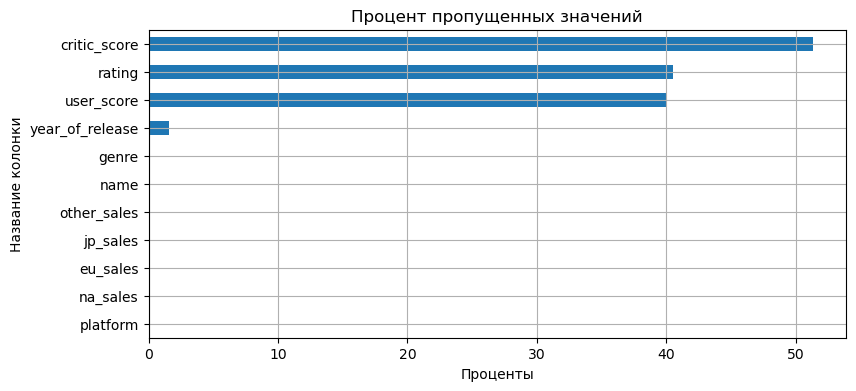

In [14]:
data_nulls = (data.isna().sum()/len(data)*100).sort_values().round(2)
data_nulls.plot(kind='barh', figsize=(9, 4), grid='True')
plt.title('Процент пропущенных значений')
plt.xlabel('Проценты')
plt.ylabel('Название колонки')
plt.show()

* Более 50% пропусков в столбце `critic_score`
* Столбцы `rating` и `user_score` содержат около 40% пропущенных значений
* Также есть пропуски в колонке `year_of_release`
* Не отражены на графике ввиду незначительного количества пропуски в колонках `name` и `year_of_release`

### Изучим данные в столбце `name`

In [17]:
# Создадим функцию для быстрого описания содержимого колонок
def describe_column(column):
        print('Nan count is', column.isna().sum())
        print(column.describe())

In [18]:
describe_column(data['name'])

Nan count is 2
count                           16713
unique                          11559
top       Need for Speed: Most Wanted
freq                               12
Name: name, dtype: object


In [19]:
# Посмотрим, что за пропуски
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


* **Столбец** `name` содержит 11559 уникальных значений.
* **Пропущенные значения:** обнаружены 2 пропуска в данных за 1993 год.
* **Возможные причины возникновения:** ошибка загрузки/выгрузки данных.
* **Аномалии:** не обнаружены.
* **Исправление:** пропуски в названии игры заполнить логически не получится. Эти строки будут удалены.
* **Тип данных:** object - соответствует ожидаемому.

### Изучим данные в столбце`platform`

In [22]:
describe_column(data['platform'])

Nan count is 0
count     16715
unique       31
top         PS2
freq       2161
Name: platform, dtype: object


In [23]:
# Приведем к нижнему регистру и проверим, совпадает ли количество уникальных значений
len(data['platform'].str.lower().value_counts())

31

* **Столбец** `platform` содержит 31 уникальное значение.
* **Пропущенные значения:** отсутствуют.
* **Аномалии:** не обнаружены.
* **Тип данных:** object - соответствует ожидаемому.

### Изучим данные в столбце `year_of_release`

In [26]:
describe_column(data['year_of_release'])

Nan count is 269
count    16446.000000
mean      2006.484616
std          5.877050
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64


In [27]:
# Посмотрим на пропуски
data[data['year_of_release'].isna()].head(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


In [28]:
# Переведем год в цельночисленный формат
data['year_of_release'] = data['year_of_release'].astype('Int64')

* **Столбец** `year_of_release` содержит информацию о годе выпуска игры: данные охватывают период с 1980 по 2016 годы.
* **Пропущенные значения:** обнаружены 269 пропусков в данных.
* **Возможные причины возникновения:** ошибка загрузки/выгрузки данных, отсутствие данных.
* **Аномалии:** не обнаружены.
* **Исправление:** некоторые названия игр содержит дату, например:  строка 183 `Madden NFL 2004`. Возможно это и есть дата выхода игры, нужно проверить эту версию.
* **Тип данных:**  - float64 не соответствует ожидаемому, заменим на Int64 для удобства дальнейшей работы.

Проверим, является ли дата в названии игры - годом ее релиза. Получим список игр, содержащих год в названии.

In [31]:
# Получим ненулевые объекты из столбца с датами
years = data[data['year_of_release'].notnull()]
# Достанем оттуда уникальные значения
years = years['year_of_release'].unique()
# Сделаем из списка строку, чтобы использовать в цикле
years = list(map(str,years))
# Соберем названия игр, в которых не заполнена дата релиза, в список 
games = data[data['year_of_release'].isna()]['name'].tolist()
# переберем в цикле названия игр, добавим в список те, в которых есть год в названии игры
games_with_year = []
for year in years:
    for game in games:
        if year in game:
            games_with_year.append(game)
games_with_year = list(set(games_with_year))
games_with_year

['Tomb Raider (2013)',
 'NBA Live 2003',
 'PDC World Championship Darts 2008',
 'PES 2009: Pro Evolution Soccer',
 'Madden NFL 2004',
 'Sega Rally 2006',
 'Madden NFL 2002',
 'Tour de France 2011',
 'NASCAR Thunder 2003',
 'NFL GameDay 2003',
 'All-Star Baseball 2005',
 'wwe Smackdown vs. Raw 2006',
 'FIFA Soccer 2004',
 'Football Manager 2007']

Из основного датафрейма возьмем срез данных по этому списку.

In [33]:
data.query('name in @games_with_year').sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
8918,All-Star Baseball 2005,XB,<NA>,Sports,0.11,0.03,0.00,0.01,75.0,8.8,E
5655,All-Star Baseball 2005,PS2,<NA>,Sports,0.16,0.12,0.00,0.04,72.0,8.6,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
13086,FIFA Soccer 2004,GBA,2003,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E
12029,FIFA Soccer 2004,GC,2003,Sports,0.05,0.01,0.00,0.00,83.0,6.2,E
2606,FIFA Soccer 2004,XB,2003,Sports,0.24,0.49,0.00,0.05,82.0,8.2,E
16079,Football Manager 2007,X360,<NA>,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
452,Madden NFL 2002,PS2,2001,Sports,2.50,0.16,0.01,0.42,94.0,7.9,E
5660,Madden NFL 2002,GBA,2001,Sports,0.23,0.08,0.00,0.01,NaN,tbd,E
4474,Madden NFL 2002,N64,2001,Sports,0.41,0.02,0.00,0.00,NaN,NaN,NaN


Видим странное. Год выпуска игры может как совпадать с годом, указанным в названии, так и отличаться от него в большую или меньшую сторону. Заполнять пропуски в этими значениями некорректно. Данные о годе выпуска игры понадобятся нам для дальнейшего исследования. Пропущенные значения года выпуска игры учитывать не будем. Строки с пропусками удалим.

### Изучим данные в столбце `genre`

In [36]:
print('Nan count is', data['genre'].isna().sum())
print()
print(data['genre'].value_counts())
print()
print(data['genre'].describe())

Nan count is 2

genre
Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: count, dtype: int64

count      16713
unique        12
top       Action
freq        3369
Name: genre, dtype: object


In [37]:
data[data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


* **Столбец** `genre` содержит 12 уникальных значений.
* **Пропущенные значения:** обнаружены 2 пропуска в данных за 1993 год.
* **Возможные причины возникновения:** ошибка загрузки/выгрузки данных.
* **Аномалии:** не обнаружены.
* **Исправление:** пропуски заполнить логически не получится. Эти строки будут удалены.
* **Тип данных:** object - соответствует ожидаемому.

### Изучим данные в столбце `na_sales`

In [40]:
describe_column(data['na_sales'])

Nan count is 0
count    16715.000000
mean         0.263377
std          0.813604
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.360000
Name: na_sales, dtype: float64


In [41]:
data.query('na_sales == na_sales.max()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E


* **Столбец** `na_sales` содержит данные о продажах игр в Северной Америке (миллионы проданных копий). Интересно, что как минимум четверть данных - это нулевые значения. Из-за максимального значения в 41 млн. проданных игр данные имеют большой размах. Вероятно среднее значение также смещено. 
* **Пропущенные значения:** отсутствуют.
* **Аномалии:** необходимо проверить данные о продажах свыше 1 млн копий. Возможно какие-то игры очень популярны в Северной Америке, а какие-то не продаются там вовсе.
* **Тип данных:** float64 - соответствует ожидаемому.

### Изучим данные в столбце `eu_sales`

In [44]:
describe_column(data['eu_sales'])

Nan count is 0
count    16715.000000
mean         0.145060
std          0.503339
min          0.000000
25%          0.000000
50%          0.020000
75%          0.110000
max         28.960000
Name: eu_sales, dtype: float64


* **Столбец** `eu_sales` содержит данные о продажах в Европе от 0 до 28.96 млн проданных копий. 
* **Пропущенные значения:** не обнаружены.
* **Аномалии:** не обнаружены.
* **Тип данных:** float64 - соответствует ожидаемому.

### Изучим данные в столбце `jp_sales`

In [47]:
describe_column(data['jp_sales'])

Nan count is 0
count    16715.000000
mean         0.077617
std          0.308853
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: jp_sales, dtype: float64


* **Столбец** `jp_sales` содержит данные о продажах игр в Японии от 0 до 10 млн проданных копий. 
* **Пропущенные значения:** не обнаружены.
* **Аномалии:** не обнаружены.
* **Тип данных:** float64 - соответствует ожидаемому.

### Изучим данные в столбце `other_sales`

In [50]:
describe_column(data['other_sales'])

Nan count is 0
count    16715.000000
mean         0.047342
std          0.186731
min          0.000000
25%          0.000000
50%          0.010000
75%          0.030000
max         10.570000
Name: other_sales, dtype: float64


* **Столбец** `other_sales` содержит данные о продажах игр в других странах от 0 до 10 млн проданных копий. 
* **Пропущенные значения:** не обнаружены.
* **Аномалии:** не обнаружены.
* **Тип данных:** float64 - соответствует ожидаемому.

### Изучим данные в столбце `critic_score`

In [53]:
describe_column(data['critic_score'])

Nan count is 8578
count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64


In [54]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [55]:
data['critic_score'] = data['critic_score'].replace(np.nan, -1)
describe_column(data['critic_score'])

Nan count is 0
count    16715.000000
mean        33.060844
std         36.299555
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         70.000000
max         98.000000
Name: critic_score, dtype: float64


* **Столбец** `critic_score` содержит оценки критиков по шкале от 0 до 100. Минимальная оценка - 13, максимальная - 98.
* **Пропущенные значения:** обнаружены 8578 пропусков в данных.
* **Возможные причины возникновения:** возможно эти игры не оценивались критиками.
* **Аномалии:** не обнаружены.
* **Исправление:** если заполнить пропуски нулем - это может повлиять на общий рейтинг при дальнейшей оценки. Удалять эти данные тоже не стоит - их слишком много и они важны для исследования. Заменим эти пропуски на значение -1 и будем помнить о них при дальнейших расчетах.
* **Тип данных:** float64 - соответствует ожидаемому.

### Изучим данные в столбце `user_score`

In [58]:
describe_column(data['user_score'])

Nan count is 6701
count     10014
unique       96
top         tbd
freq       2424
Name: user_score, dtype: object


In [59]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [60]:
data.query('user_score == "tbd"').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,-1.0,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,-1.0,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.00,0.18,-1.0,tbd,E
726,Dance Dance Revolution X2,PS2,2009,Simulation,1.09,0.85,0.00,0.28,-1.0,tbd,E10+
821,The Incredibles,GBA,2004,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
881,Who wants to be a millionaire,PC,1999,Misc,1.94,0.00,0.00,0.00,-1.0,tbd,E
1047,Tetris Worlds,GBA,2001,Puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E


TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков, которые надо заполнить. Таким образом, TBD в нашем случае это значения ***nan***, так как для некоторых игр, по всей видимости, недостаточно оценок пользователей. 

In [62]:
data['user_score'] = data['user_score'].replace('tbd', -1)
data['user_score'] = data['user_score'].replace(np.nan, -1)
describe_column(data['user_score'])

Nan count is 0
count     16715
unique       96
top          -1
freq       9125
Name: user_score, dtype: int64


In [63]:
data['user_score'] = data['user_score'].astype('float64')

* **Столбец** `user_score` содержит оценки пользователей по шкале от 0 до 10. Минимальная оценка - 0, максимальная - 9.7.
* **Пропущенные значения:** обнаружены 6701 пропуск в данных.
* **Возможные причины возникновения:** возможно эти игры не оценивались пользователями, или нет информации об этих оценках.
* **Аномалии:** обнаружены значения `tbd` - аббревиатура от английского To Be Determined (будет определено). 
* **Исправление:** по сути это значения nan, заменили пропуски. Для дальнейшей работы все значения nan заменим на -1.
* **Тип данных:** после замены пропусков столбец содержит только числовые значения и значения nan, приведем его к формату float64. 

### Изучим данные в столбце `rating`

In [66]:
describe_column(data['rating'])

Nan count is 6766
count     9949
unique       8
top          E
freq      3990
Name: rating, dtype: object


In [67]:
# Заменим пропущенные значение на 'unknown'
data['rating'] = data['rating'].replace(np.nan, 'unknown')

In [68]:
data['rating'].value_counts()

rating
unknown    6766
E          3990
T          2961
M          1563
E10+       1420
EC            8
K-A           3
RP            3
AO            1
Name: count, dtype: int64

In [69]:
# Категория "K-A" - устаревшее обозначение для категории "E". Исправим
data['rating'] = data['rating'].replace('K-A', 'E')

ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию:
* «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет.
* «E», "K-A" («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов (ранее с 6 лет). 
* «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше».
* «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. 
* «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.
* «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет.
* «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. 

* **Столбец** `rating` содержит рейтинг от организации . 
* **Пропущенные значения:** обнаружено 6766 пропущенных значений.
* **Возможные причины возникновения:** возможно эти игры не оценивались ESRB, или нет информации об этих оценках.
* **Аномалии:** не обнаружены. 
* **Исправление:** Для дальнейшей работы все пропущенные значения заменим на *unknown*, категории "К-А" присвоено значение "Е".
* **Тип данных:** object - соответствует ожидаемому.

### Удалим пропущенные значения
Строки с пропущенными значениями в столбцах `name` и `year_of_release` удалим из датафрейма

In [73]:
data = data.dropna(subset=['name', 'year_of_release'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


### Добавим информацию о суммарных продажах во всех регионах 
Добавим столбец `total_sales`, содержащий сумму значений столбцов `na_sales`, `eu_sales`, `jp_sales`, `other_sales`

In [75]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38


**В процессе предобработки данных были реализованы следующие действия:**
* Названия столбцов приведены к нижнему регистру;
* Изучен каждый столбец датафрейма, обнаружены пропущенные значения в столбцах `name`, `year_of_release`, `genre`, `critic_score`, `user_score`, `rating`;
* Пропуски в столбцах `name`, `year_of_release` не подлежали восстановлению какими-либо логичными способами и были удалены;
* Обнаружено большое количество пропусков в столбцах `critic_score`, `user_score`, `rating` - вероятно, некоторые игры не имеют достаточного количества оценок критиков и пользователей для попадания в рейтинг;
* Обнаружена аномалия: в столбце `user_score` помимо числовых значений присутсвует значение 'tbd' - заменено на NAN, так как имеет тот же смысл;
* Формат данных преобразован к оптимальному;
* Добавлен столбец с информацией о суммарных продажах игр во всех регионах.

## Исследовательский анализ данных

### Количество игр, выпущенных в разные годы

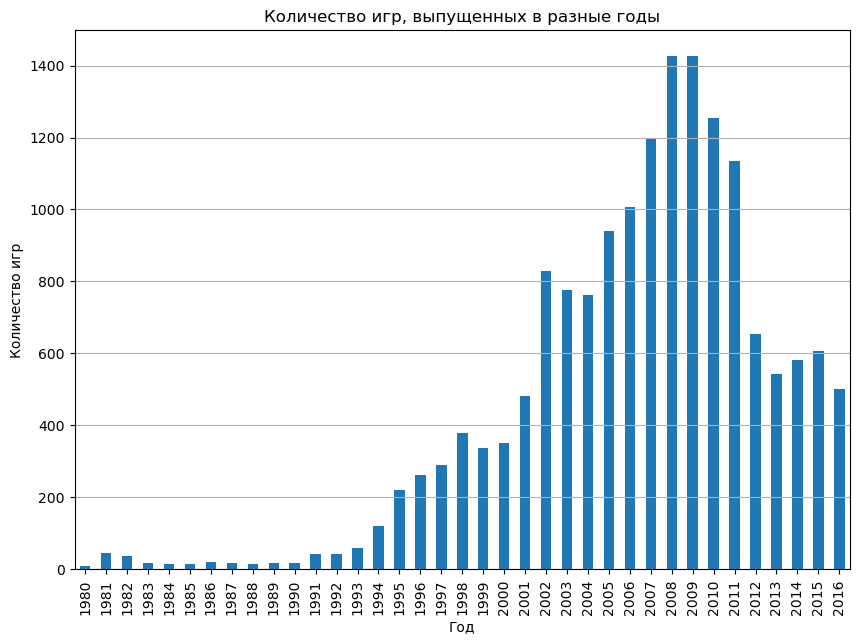

In [79]:
data.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(10, 7))
plt.title('Количество игр, выпущенных в разные годы')
plt.grid (axis='y')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

In [80]:
data.groupby('year_of_release')['name'].count().reset_index()

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


В период с 1980 по 1993 год количество выпущенных игр было невелико - максимум 60 игр в 1993 году. С 1994 года, с развитием компьютерных технологий, это количество ежегодно увеличивается, достигая к 1998 году показателя в 379 выпущенных игр. Резкий скачок в 2002, когда количество игр перевалило за 800, приходится на период развития технологий хранения и обработки данных,  совершенствования технологий трехмерной графики. Значения достигают пика в 2008-2009 годах на отметке свыше 1400 выпущенных игр в год. Это время, когда персональный компьютер стал неотъемлемой частью жизни, работы и отдыха многих людей, а компьютерные игры стали частью культуры общества. С 2012 года резкий спад, на смену компьютерным играм приходят мобильные приложения и браузерные игры. Новых игр в период с 2012 по 2016 появляется вдвое меньше, около 600 ежегодно.

Актуальной информацией о количестве игр будут данные за период с 2012 по 2016 год. 

### Динамика продаж по платформам
Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 

In [83]:
data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).reset_index()

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Вывели десятку платформ-лидеров суммарных продаж. Постороим графики, узнаем, за какой характерный срок появляются новые и исчезают старые платформы.

In [85]:
# достанем названия платформ из топ-10 в список
top_10 = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).index.tolist()
# сделаем срез по этому списку
data.query('platform in @top_10').pivot_table(
                                  index=['platform', 'year_of_release'],
                                  values='total_sales',
                                  aggfunc='sum')

total_sales
platform year_of_release             
3DS      2011                   63.20
         2012                   51.36
         2013                   56.57
         2014                   43.76
         2015                   27.78
...                               ...
X360     2012                   99.74
         2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52

[97 rows x 1 columns]

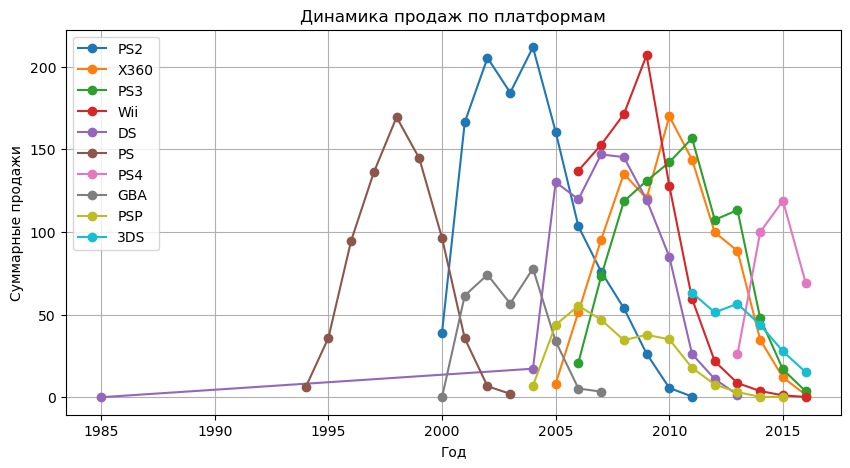

In [86]:
for i in top_10:
    (data.query('platform == @i').pivot_table(
                                  index = 'year_of_release', 
                                  values = 'total_sales', 
                                  aggfunc = 'sum')['total_sales']
    .plot(kind='line', style='-o', figsize = (10, 5), label=i, grid=True)
    )
    plt.title('Динамика продаж по платформам')
    plt.xlabel('Год')
    plt.ylabel('Суммарные продажи')
    plt.legend() 


In [87]:
years_of_life = data.query('platform in @top_10').pivot_table(
                                  index='platform',
                                  values='year_of_release',
                                  aggfunc=['min', 'max']).reset_index().rename(columns={'min':'beginning', 'max':'end'})
years_of_life['duration'] = years_of_life['end'] - years_of_life['beginning'] + 1
years_of_life

,platform,beginning,end,duration
,,year_of_release,year_of_release,
0,3DS,2011,2016,6
1,DS,1985,2013,29
2,GBA,2000,2007,8
3,PS,1994,2003,10
4,PS2,2000,2011,12
5,PS3,2006,2016,11
6,PS4,2013,2016,4
7,PSP,2004,2015,12
8,Wii,2006,2016,11


На графике непонятный длинный хвост у платформы DS, однако Гугл говорит, что Nintendo DS была выпущена в 2004 году. PS4 выпущена в 2013 на смену PS3, прошла пик роста продаж, но еще не завершила свой жизненный путь. 

Получается, жизненный цикл платформы в среднем 10-11 лет, пик развития на 4-5 году жизни, затем постепенное угасание и выход новой версии платформы, заменяющей предыдущую, через 7-8 лет.

### Определение актуального периода
   
    Исходя из средней продолжительности жизненного цикла и срока появления новой версии платформы, для построения прогноза возьмем данные за период с 2013 по 2016 годы. Сфера игр быстро меняется, этот подход позволит уловить новые тенденции динамично развивающегося рынка.


In [90]:
actual_data = data.query('year_of_release >= 2013')
actual_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2233 non-null   object 
 1   platform         2233 non-null   object 
 2   year_of_release  2233 non-null   Int64  
 3   genre            2233 non-null   object 
 4   na_sales         2233 non-null   float64
 5   eu_sales         2233 non-null   float64
 6   jp_sales         2233 non-null   float64
 7   other_sales      2233 non-null   float64
 8   critic_score     2233 non-null   float64
 9   user_score       2233 non-null   float64
 10  rating           2233 non-null   object 
 11  total_sales      2233 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 229.0+ KB


C:\Users\User\AppData\Local\Temp\ipykernel_16012\2355886972.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  actual_data = data.query('year_of_release >= 2013')


### Динамика продаж за 2013 - 2016 годы

Проверим, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.

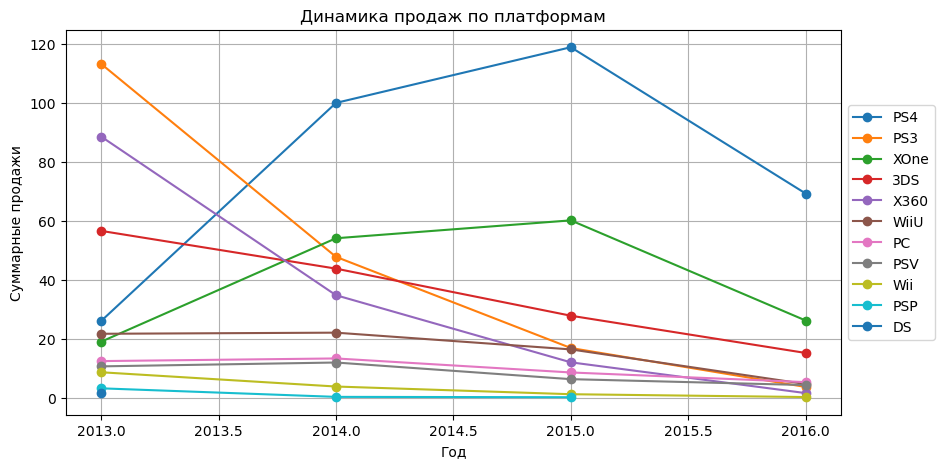

In [93]:
platforms = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index.tolist()

for i in platforms:
    (actual_data.query('platform == @i').pivot_table(
                                  index = 'year_of_release', 
                                  values = 'total_sales', 
                                  aggfunc = 'sum')['total_sales']
    .plot(kind='line', style='-o', figsize = (10, 5), label=i, grid=True)
    )
    plt.title('Динамика продаж по платформам')
    plt.xlabel('Год')
    plt.ylabel('Суммарные продажи')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [94]:
actual_data_2016 = actual_data.query('year_of_release == 2016')
actual_data_2016.pivot_table(index = 'platform', 
                            values = 'total_sales',
                            aggfunc = 'sum').sort_values(by='total_sales', ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_16012\1230459408.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  actual_data_2016 = actual_data.query('year_of_release == 2016')


,total_sales
platform,
PS4,69.25
XOne,26.15
3DS,15.14
PC,5.25
WiiU,4.60
PSV,4.25
PS3,3.60
X360,1.52
Wii,0.18


График показывает общую тенденцию снижения продаж компьютерных игр. Игры платформ PSP, PS2 и DS исчезли из продаж до 2015 года. 
Платформы PS3, X360, Wii показывают значительный спад продаж и, по всей видимости, находятся на завершающем этапе своего жизненного цикла.
Платформы PC, WiiU, PSV развиваются равномерно, и хоть продажи игр, подчиняясь общей тенденции, упали, - эти платформы имеют потенциал роста.
Лидерами продаж в 2016 году были платформы PS4, XOne, 3DS. Эти платформы появились относительно недавно, находятся в начале своего жизненного цикла, а значит могут стать потенциально прибыльными в перспективе ближайших 5 лет.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

In [97]:
actual_data['total_sales'].describe()

count    2233.000000
mean        0.488442
std         1.235226
min         0.010000
25%         0.030000
50%         0.110000
75%         0.400000
max        21.050000
Name: total_sales, dtype: float64

Text(0.5, 1.0, 'Глобальные продажи игр по платформам')

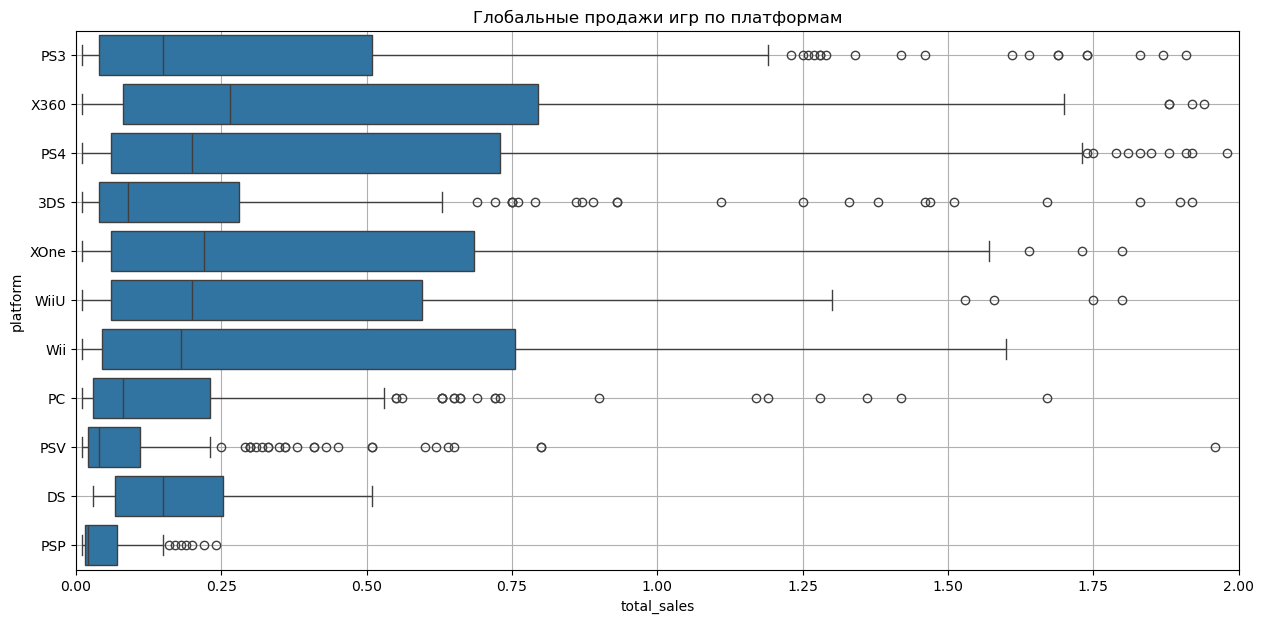

In [98]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(data=actual_data, x='total_sales', y='platform')
ax.set_xlim(0, 2)
ax.grid()    
ax.set_title('Глобальные продажи игр по платформам')

<div class="alert alert-block alert-info">
Для графика глобальных продаж игр выберем 5 платформ, с максимальными продажами в актуальном периоде.
    
</div>

In [100]:
top_5_platforms = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).reset_index()
top_5_platforms = top_5_platforms['platform'].tolist()
actual_top_5_platforms = actual_data.query('platform in @top_5_platforms')

Text(0.5, 1.0, 'Глобальные продажи игр по платформам')

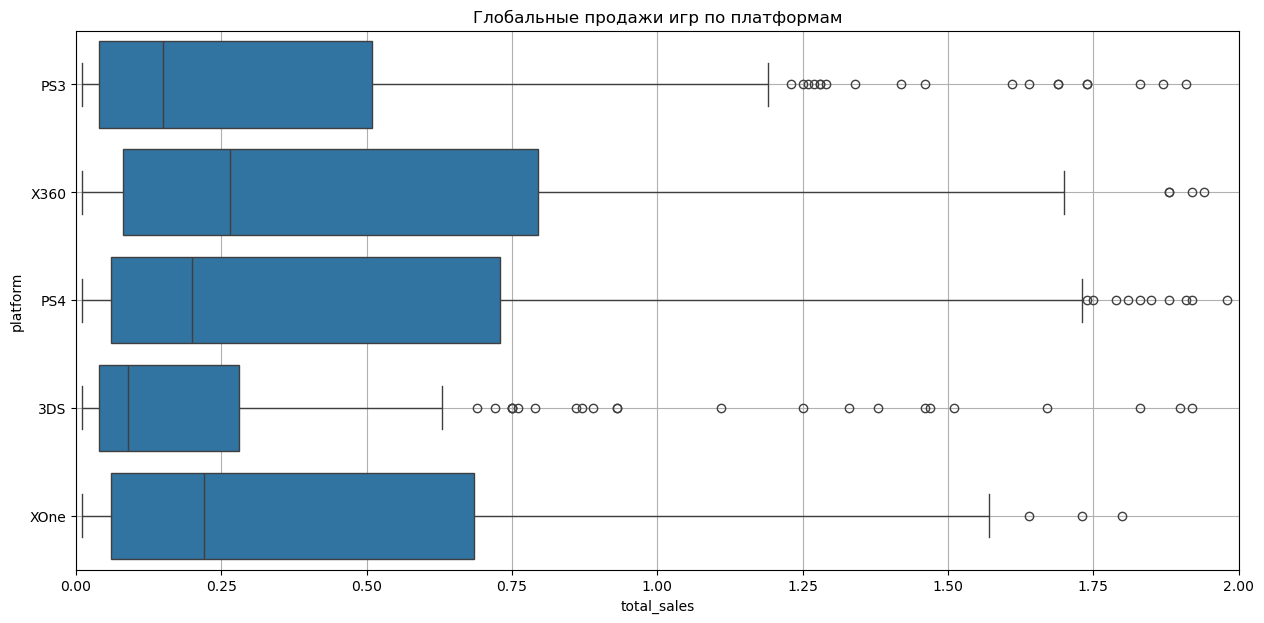

In [101]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(data=actual_top_5_platforms, x='total_sales', y='platform')
ax.set_xlim(0, 2)
ax.grid()    
ax.set_title('Глобальные продажи игр по платформам')

На графике видно большое количество аномальных значений, ось Х ограничена значением в 2 млн. проданных копий. Лидер по глобальным продажам за актуальный период - платформа Х360. Основные продажи каждой из платформ не превышают 750 тысяч копий.

### Влияние отзывов пользователей и критиков на продажи 
Посмотрим, как влияют на продажи отзывы пользователей и критиков. Для построения диаграммы рассеяния и подсчета корреляции между отзывами и продажами возьмем платформу `PC` - на этой платформе выпущено много игр, она популярна среди пользователей, давно присутствует на рынке и по ней большое количество данных для исследования. Отберем данные по платформе, где нет пропущенных значений в отзывах пользователей и критиков.

In [104]:
pc_data = data[data['platform'] == 'PC']
pc_data = pc_data[(pc_data['user_score'] > 0) & (pc_data['critic_score'] > 0)].copy()

pc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 688 entries, 85 to 16705
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             688 non-null    object 
 1   platform         688 non-null    object 
 2   year_of_release  688 non-null    Int64  
 3   genre            688 non-null    object 
 4   na_sales         688 non-null    float64
 5   eu_sales         688 non-null    float64
 6   jp_sales         688 non-null    float64
 7   other_sales      688 non-null    float64
 8   critic_score     688 non-null    float64
 9   user_score       688 non-null    float64
 10  rating           688 non-null    object 
 11  total_sales      688 non-null    float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 70.5+ KB


Подсчитаем корреляцию между отзывами пользователей и продажами игр на платформе PC, построим график.

In [106]:
pc_data['user_score'].corr(pc_data['total_sales'])

0.00359623233784511

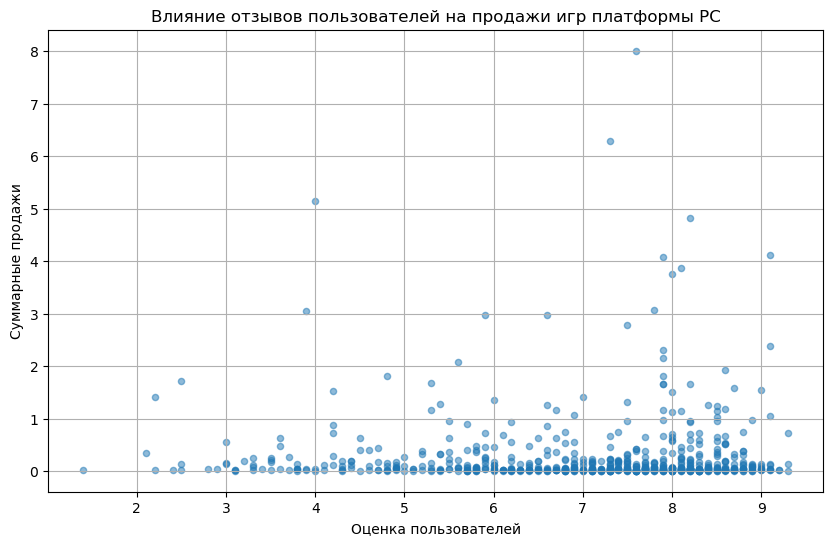

In [107]:
pc_data.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5, grid=True, figsize=(10, 6))
plt.title('Влияние отзывов пользователей на продажи игр платформы PC')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')
plt.show()

Подсчитаем корреляцию между отзывами критиков и продажами игр на платформе PC, построим график.

In [109]:
pc_data['critic_score'].corr(pc_data['total_sales'])

0.257260981042733

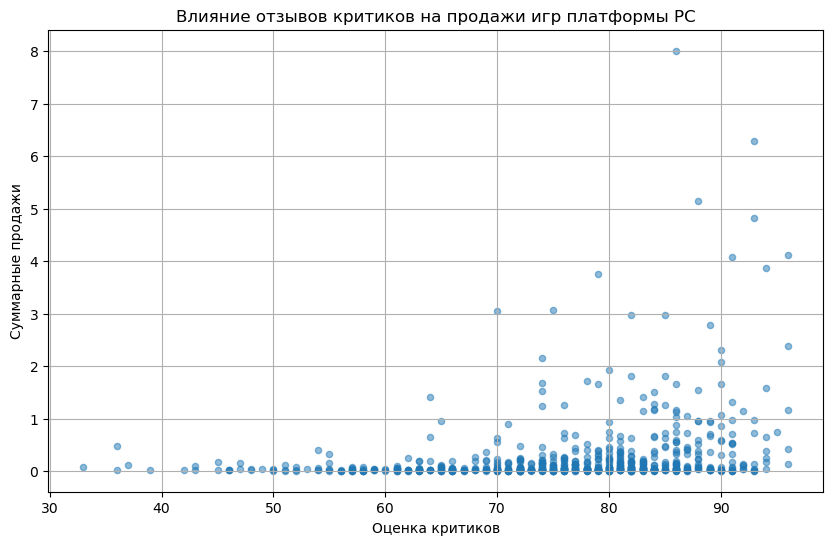

In [110]:
pc_data.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5, grid=True, figsize=(10, 6))
plt.title('Влияние отзывов критиков на продажи игр платформы PC')
plt.xlabel('Оценка критиков')
plt.ylabel('Суммарные продажи')
plt.show()

Коэффициент корреляции между отзывами пользователей и продажами игр на платформе PC составляет ~0.0036, что может говорить о слабом влиянии этих отзывов на продажи. Возможно пользователи недостаточно часто пишут отзывы на игры, или каждый покупает игры на свой вкус, не опираясь на оценки других пользователей.

По-другому обстоят дела с отзывами критиков - тут коэффициент корреляции ~0.257, и можно предположить, что существует взаимосвязь между высокими отзывами критиков и общими продажами игр этой платформы. Вероятно многие покупатели при выборе игр, учитывают мнение критиков.

Посмотрим на мировые продажи за актуальный период 2013 - 2016 гг.

In [112]:
actual_data = actual_data[(actual_data['user_score'] > 0) & (actual_data['critic_score'] > 0)].copy()

In [113]:
actual_data['user_score'].corr(pc_data['total_sales'])

-0.10923502736171779

In [114]:
actual_data['critic_score'].corr(pc_data['total_sales'])

0.19412407903472956

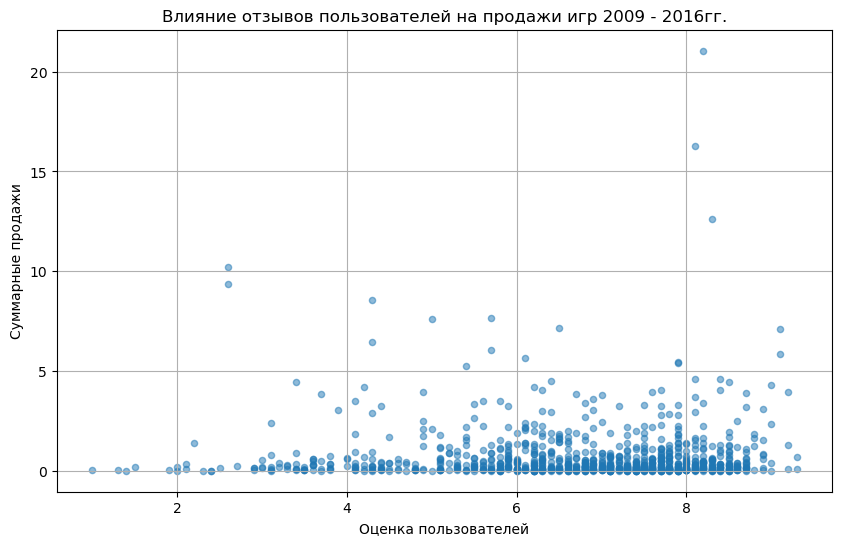

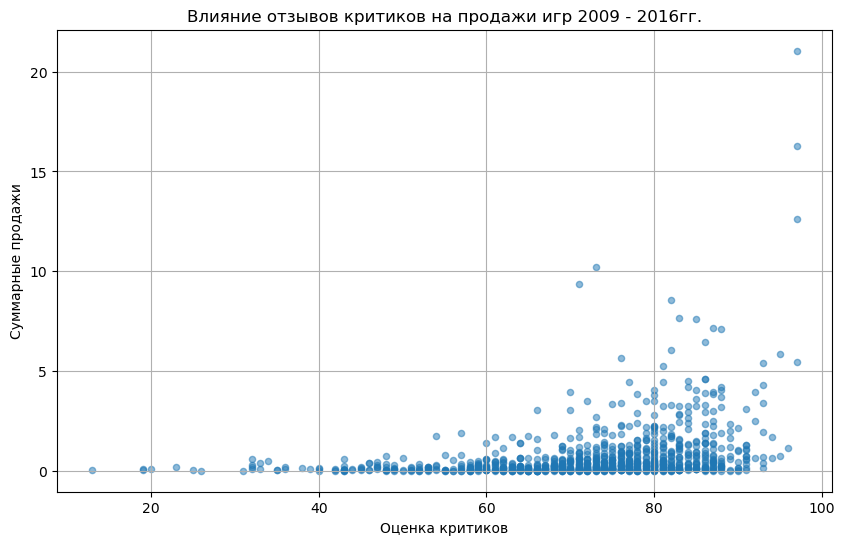

In [115]:
actual_data.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5, grid=True, figsize=(10, 6))
plt.title('Влияние отзывов пользователей на продажи игр 2009 - 2016гг.')
plt.xlabel('Оценка пользователей')
plt.ylabel('Суммарные продажи')
plt.show()
actual_data.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5, grid=True, figsize=(10, 6))
plt.title('Влияние отзывов критиков на продажи игр 2009 - 2016гг.')
plt.xlabel('Оценка критиков')
plt.ylabel('Суммарные продажи')
plt.show()

Мировые продажи игр  слабо коррелируют с отзывами пользователей - видна некоторая хаотичность на графике. Присутствуют высокие продажи игр с малыми пользовательскими рейтингами. Возможна и общая тенденция - популярные игры чаще оцениваются пользователями. А вот с оценками критиков, как и в случае с платформой PC, на графике видна положительная корреляция. Значит высокие оценки критиков могут способствовать продажам игр.

### Распределение игр по жанрам
Посмотрим на общее распределение игр по жанрам. Выясним, есть ли самые прибыльные жанры. Проверим, выделяются ли жанры с высокими и низкими продажами.

In [118]:
actual_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False).reset_index()

,genre,total_sales
0,Action,231.62
1,Shooter,170.99
2,Sports,115.06
3,Role-Playing,61.21
4,Racing,34.09
5,Platform,31.98
6,Misc,19.39
7,Fighting,17.79
8,Simulation,12.07
9,Adventure,10.03


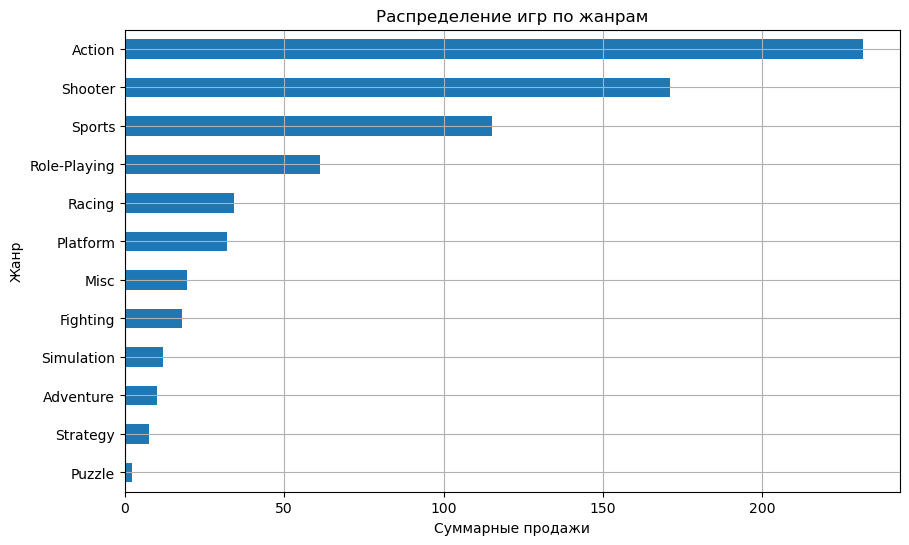

In [119]:
actual_data.groupby('genre')['total_sales'].sum().sort_values(ascending=True).\
                                            plot(kind='barh', figsize=(10, 6), grid=True)
plt.title('Распределение игр по жанрам')
plt.xlabel('Суммарные продажи')
plt.ylabel('Жанр')
plt.show()

В разрезе суммарных продаж лидируют игры жанра `Action` и `Shooter`. Похоже, игры класса 'беги - стреляй' никогда не выйдут из моды.  Следующую позицию занимают спортивные игры. Середина рейтинга отдана ролевым и платформенным играм, гонкам и симуляторам. На нижних позициях рейтинга стратегии, приключения и пазлы. Что касается прибыльности игр разных жанров, полагаю затраты на производство топовых стрелялок несравненно больше, чем стоимость производства пазлов и стратегий. Этот момент стоит учитывать при прогнозе прибыльности платформ.


<div class="alert alert-block alert-info">
Рассмотрим средние и медианные продажи игр по жанрам
</div>

In [121]:
actual_data.groupby('genre')['total_sales'].mean().sort_values(ascending=False)

genre
Shooter         1.295379
Sports          1.046000
Action          0.749579
Platform        0.639600
Racing          0.577797
Role-Playing    0.481969
Simulation      0.464231
Misc            0.461667
Fighting        0.423571
Puzzle          0.320000
Strategy        0.288077
Adventure       0.218043
Name: total_sales, dtype: float64

In [122]:
actual_data.groupby('genre')['total_sales'].median().sort_values(ascending=False)

genre
Shooter         0.585
Sports          0.540
Misc            0.345
Platform        0.255
Action          0.220
Strategy        0.220
Fighting        0.195
Role-Playing    0.180
Racing          0.180
Simulation      0.150
Puzzle          0.100
Adventure       0.070
Name: total_sales, dtype: float64

Анализ средних и медианных значений продаж игр каждого жанра сместил акценты в пользу шутеров и спортивных игр. Но аутсайдеры остались прежними - пазлы и приключенческие игры.

## Портрет пользователя каждого региона
### Самые популярные платформы 

Добавим столбцы с процентом продаж каждой игры от общих продаж по регионам

In [126]:
actual_data['na_sales_proportion'] = (actual_data['na_sales'] / actual_data['na_sales'].sum() * 100).round(2)
actual_data['eu_sales_proportion'] = (actual_data['eu_sales'] / actual_data['eu_sales'].sum() * 100).round(2)
actual_data['jp_sales_proportion'] = (actual_data['jp_sales'] / actual_data['jp_sales'].sum() * 100).round(2)
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,na_sales_proportion,eu_sales_proportion,jp_sales_proportion
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,2.31,3.30,1.98
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,3.18,1.87,0.12
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,1.30,2.29,0.77
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24,2.22,0.93,0.08
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36,1.35,1.32,0.77


In [127]:
# Сгруппирум продажи по платформам в каждом регионе, возьмем сумму продаж и суммарный процент продаж, выберем 5 верхних значений
na_top_platforms = actual_data.pivot_table(index='platform', values=('na_sales', 'na_sales_proportion'), aggfunc='sum').\
                               sort_values(by='na_sales', ascending=False).reset_index().head(5)

eu_top_platforms = actual_data.pivot_table(index='platform', values=('eu_sales', 'eu_sales_proportion'), aggfunc='sum').\
                               sort_values(by='eu_sales', ascending=False).reset_index().head(5)

jp_top_platforms = actual_data.pivot_table(index='platform', values=('jp_sales', 'jp_sales_proportion'), aggfunc='sum').\
                               sort_values(by='jp_sales', ascending=False).reset_index().head(5)

# Соберем в одну таблицу
top_platforms = pd.merge(na_top_platforms, eu_top_platforms, left_index=True, right_index=True)
top_platforms = pd.merge(top_platforms, jp_top_platforms, left_index=True, right_index=True)
top_platforms.drop(['na_sales', 'eu_sales', 'jp_sales'], axis= 1 , inplace= True )
top_platforms.rename(columns = {'platform_x':'na_platform', 'platform_y':'eu_platform', 'platform':'jp_platform'}, inplace = True )
top_platforms

,na_platform,na_sales_proportion,eu_platform,eu_sales_proportion,jp_platform,jp_sales_proportion
0,PS4,27.79,PS4,40.85,3DS,28.58
1,XOne,25.11,PS3,15.71,PS3,22.14
2,X360,16.78,XOne,15.27,PS4,18.91
3,PS3,13.94,X360,9.61,WiiU,16.85
4,WiiU,7.59,PC,7.91,PSV,11.46


* Самая популярная платформа у пользователей из Европы и Северной Америки - `PS4`. Она же третья по популярности в Японии.
* Платформы `XOne` и `X360` вошли в пятерку лидеров и в Северной Америке и в Европе, однако в Японии они не так популярны.
* Платформа `PS3` присутствует в рейтингах каждого региона, занимая 2 место в Европе и Японии и 4 в Северной Америке.
* Рейтинг популярности платформ среди пользователей из Японии существенно отличается от остальных: на первом месте `3DS`, далее два поколения PS, и наконец `WiiU` и `PSV`.

Таким образом, есть платформы, пользующиеся популярностью во всех регионах - это PS3 и 	PS4.
Рейтинг популярности платформ близок у пользователей Европы и Америки. В него вошли платформы X360, PS3, PS4 и XOne. В то время как у пользователей из Японии свои предпочтения - многие из них выбирают 3DS и WiiU.

### Самые популярные жанры

In [130]:
# Сгруппирум продажи по жанрам в каждом регионе, возьмем сумму продаж и суммарный процент продаж, выберем 5 верхних значений
na_top_genre = actual_data.pivot_table(index='genre', values=('na_sales', 'na_sales_proportion'), aggfunc='sum').\
                               sort_values(by='na_sales', ascending=False).reset_index().head(5)

eu_top_genre = actual_data.pivot_table(index='genre', values=('eu_sales', 'eu_sales_proportion'), aggfunc='sum').\
                               sort_values(by='eu_sales', ascending=False).reset_index().head(5)

jp_top_genre = actual_data.pivot_table(index='genre', values=('jp_sales', 'jp_sales_proportion'), aggfunc='sum').\
                               sort_values(by='jp_sales', ascending=False).reset_index().head(5)

# Соберем в одну таблицу
top_genres = pd.merge(na_top_genre, eu_top_genre, left_index=True, right_index=True)
top_genres = pd.merge(top_genres, jp_top_genre, left_index=True, right_index=True)
top_genres.drop(['na_sales', 'eu_sales', 'jp_sales'], axis= 1 , inplace= True )
top_genres.rename(columns = {'genre_x':'na_genre', 'genre_y':'eu_genre', 'genre':'jp_genre'}, inplace = True )
top_genres

,na_genre,na_sales_proportion,eu_genre,eu_sales_proportion,jp_genre,jp_sales_proportion
0,Action,31.99,Action,32.97,Action,29.41
1,Shooter,26.73,Shooter,23.26,Role-Playing,25.04
2,Sports,16.85,Sports,17.01,Shooter,10.62
3,Role-Playing,7.65,Role-Playing,6.96,Platform,8.40
4,Platform,4.52,Racing,6.10,Misc,6.27


* Лидирующие жанры игр в Северной Америке, Европе и Японии одинаковы: пользователи предпочитают "Action".
* "Shooter", "Sports" и "Role-Playing" - следующие по популярности в Европе и Северной Америке. В то время как в Японии "Role-Playing" на втором, а "Shooter" на третьем месте.
* Особенность Северной Америки - популярность жанра "Platform".
* В Европе пользователи предпочитают игры жанра "Racing" - он не вошел в рейтинги остальных регионов.
* Характерная особенность продаж в Японии - пользователями любимы игры жанра "Platform" и "Misc" - они занимают четвертую и пятую строчку рейтинга этого региона.

Подводя итог: пользователи всех трех регионов предпочитают в разных пропорциях игры жанров `Action`, `Shooter`, и `Role-Playing`.	

### Влияние рейтинга ESRB на продажи в отдельном регионе

In [133]:
# Сгруппирум продажи в каждом регионе по рейтингу, возьмем сумму продаж и суммарный процент продаж
na_rating = actual_data.pivot_table(index='rating', values=('na_sales', 'na_sales_proportion'), aggfunc='sum').\
                               sort_values(by='na_sales', ascending=False).reset_index()

eu_rating = actual_data.pivot_table(index='rating', values=('eu_sales', 'eu_sales_proportion'), aggfunc='sum').\
                               sort_values(by='eu_sales', ascending=False).reset_index()

jp_rating = actual_data.pivot_table(index='rating', values=('jp_sales', 'jp_sales_proportion'), aggfunc='sum').\
                               sort_values(by='jp_sales', ascending=False).reset_index()

# Соберем в одну таблицу
ratings = pd.merge(na_rating, eu_rating, left_index=True, right_index=True)
ratings = pd.merge(ratings, jp_rating, left_index=True, right_index=True)
ratings.drop(['na_sales', 'eu_sales', 'jp_sales'], axis= 1 , inplace= True )
ratings.rename(columns = {'rating_x':'na_rating', 'rating_y':'eu_rating', 'rating':'jp_rating'}, inplace = True )
ratings

,na_rating,na_sales_proportion,eu_rating,eu_sales_proportion,jp_rating,jp_sales_proportion
0,M,50.35,M,49.11,T,33.24
1,E,21.62,E,25.00,E,28.52
2,T,14.97,T,14.09,M,26.01
3,E10+,12.89,E10+,10.83,E10+,11.39
4,unknown,0.36,unknown,0.73,unknown,0.46


Расшифруем значения сокращений:
* «E»(«Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов (ранее с 6 лет).
* «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.
* «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.
* «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше».
* unknown - рейтинг не известен.
* «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. 

Пользователи Европы и Северной Америки показывают одинаковые предпочтения: 50% рынка составляют игры для взрослых, около 22-25% - игры категории "Е" для всех возрастов, оставшееся приходится на игры для подростков (порядка 14%) и игры для детей от 10 лет (13% и 11% соответственно) .

Рынок для пользователей Японии распределен иначе: 33% проданных игр предназначены для подростков, 29% - игры для всех возрастов, 26% - игры для взрослых и около 11% игры категории 10+. 

Составляя портрет типичного пользователя каждого региона, можно отметить сходства для пользователей Европы и Северной Америки: 
это взрослые пользователи, предпочитающие игры на платформах PS4 и XOne в жанрах Action, Shooter и Sports. Портрет типичного пользователя из Японии - дети, подростки, либо взрослые, предпочитающие игры для детей в жанрах Role-Playing и Action на платформах PS3 или 3DS.

## Проверим гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем гипотезы:
* Н0: средние пользовательские рейтинги платформы Xbox One равны рейтингам платформы PC;
* Н1: средние пользовательские рейтинги платформ Xbox One и PC отличаются;

Для проверки гипотезы используем данные об оценках пользователей каждой платформы. Так как наши группы пользователей не зависят друг от друга, выборки разного размера, и мы предполагаем, что дисперсии выборок не равны, будем сравнивать средние двух генеральных совокупностей, используя t-test для двух независимых групп, указывая параметр `equal_var`=False.

Возьмем уровень значимости равный 5%

In [139]:
# Возьмем срез данных по двум платформам
x_one_user_score = actual_data.query('user_score > 0 and platform == "XOne"')
pc_user_score = actual_data.query('user_score > 0 and platform == "PC" ')

alpha = 0.05
results = st.ttest_ind(x_one_user_score['user_score'], pc_user_score['user_score'], equal_var=False)

print('p-value=', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value= 0.17882648263401307
Нет оснований отвергнуть нулевую гипотезу


In [140]:
actual_data.query('user_score > 0 and (platform == "XOne" or platform == "PC") ').groupby('platform')['user_score'].mean()

platform
PC      6.302027
XOne    6.538182
Name: user_score, dtype: float64

Так как p-value меньше заданного уровня значимости, нет оснований утверждать, что пользовательские рейтинги выбранных платформ имеют существенные статистические различия при выбранной чувствительности теста. Эту версию отчасти подтверждают средние значения оценок пользователей: они составляют 6.302 для платформы PC и 6.5382 для платформы XOne.

### Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем гипотезы:
* Н0: средние пользовательские рейтинги жанра Action и Sports равны;
* Н1: средние пользовательские рейтинги жанров Action и Sports отличаются.

Для проверки гипотезы используем данные об оценках пользователей игр выбранных жанров. Так как наши группы пользователей не зависят друг от друга, выборки разного размера, и мы предполагаем, что дисперсии выборок не равны, будем сравнивать средние двух генеральных совокупностей, используя t-test для двух независимых групп, указывая параметр `equal_var`=False.

Возьмем уровень значимости равный 5%.

In [144]:
# Возьмем срез данных по двум жанрам
action_genre_user_score = actual_data.query('user_score > 0 and genre == "Action"')
sports_user_score = actual_data.query('user_score > 0 and genre == "Sports" ')

alpha = 0.05
results = st.ttest_ind(action_genre_user_score['user_score'], sports_user_score['user_score'], equal_var=False)

print('p-value=', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value= 1.0496920005008588e-13
Отвергаем нулевую гипотезу


In [145]:
actual_data.query('user_score > 0 and (genre == "Action" or genre == "Sports")').groupby('genre')['user_score'].mean()

genre
Action    6.936246
Sports    5.665455
Name: user_score, dtype: float64

Исследование опровергает гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports равны, данные статистически отличаются при выбранном уровне чувствительности теста. Более того, учитывая, что p-value стремится к нулю, даже повышение уровня значимости до 1% даст тот же результат. Средние значения рейтингов Action - 6.94, Sports - 5.67.

## Общий вывод

В процессе исследования были реализованы следующие действия:
- 1. Импортированы и изучены данные.


- 2. В процессе предобработки данных:

    * Названия столбцов приведены к нижнему регистру;
    * Визуализированы пропущенные значения;
    * Изучен каждый столбец датафрейма, обнаружены пропущенные значения в столбцах name, year_of_release, genre, critic_score, user_score, rating;
    * Пропуски в столбцах name, year_of_release не подлежали восстановлению какими-либо логичными способами и были удалены;
    * Обнаружено большое количество пропусков в столбцах critic_score, user_score, rating - вероятно, некоторые игры не имеют достаточного количества оценок критиков и пользователей для попадания в рейтинг. Эти пропуски были заменены значением -1;
    * Обнаружена аномалия: в столбце user_score помимо числовых значений присутсвует значение 'tbd' - также заменено -1, так как является по сути отсутствием информации (пропуском);
    * Формат данных преобразован к оптимальному;
    * Добавлен столбец с информацией о суммарных продажах игр во всех регионах.
    

- 3.Проведен исследовательский анализ данных:

    * Изучено количество игр, выпущенных в разные годы, принято решение, что актуальной информацией о количестве игр будут данные за период с 2012 по 2016 год.
    * Построен график динамики продаж по платформам, сделан вывод о том, жизненный цикл платформы в среднем составляет 10-11 лет, пик развития на 4-5 году жизни, затем постепенное угасание и выход новой версии платформы, заменяющей предыдущую, через 7-8 лет.
    * На основании этих данных для построения прогноза на 2017 год выбраны данные за период ***с 2013 по 2016 годы.***
    * График динамики продаж актуального периода выявил общую тенденцию снижения продаж компьютерных игр. Игры платформ PSP, PS2 и DS исчезли из продаж до 2015 года. Платформы PS3, X360, Wii показывают значительный спад продаж и, по всей видимости, находятся на завершающем этапе своего жизненного цикла. Платформы PC, WiiU, PSV развиваются равномерно, и хоть продажи игр, подчиняясь общей тенденции, упали, - эти платформы имеют потенциал роста. Лидерами продаж в 2016 году были платформы PS4, XOne, 3DS. Эти платформы появились относительно недавно, находятся в начале своего жизненного цикла, а значит могут стать потенциально прибыльными в перспективе ближайших 5 лет.
    * Было исследовано влияние отзывов пользователей и критиков на продажи игр на примере платформы PC. Сделан вывод, о том, что продажи игр слабо коррелируют с отзывами пользователей. Возможна и общая тенденция - популярные игры чаще оцениваются пользователями. В то время как высокие оценки критиков могут способствовать продажам игр.
    * Изучено распределение игр по жанрам. В разрезе суммарных продаж лидируют игры жанра ***Shooter и Spots.*** Следующую позицию занимают экшн-игры. Середина рейтинга отдана ролевым и платформенным играм, гонкам и симуляторам. На нижних позициях рейтинга стратегии, приключения и пазлы. Что касается прибыльности игр разных жанров, можно предположить, что затраты на производство топовых игр (шутеров и экшн-игр) несравненно больше, чем стоимость производства пазлов и стратегий. Этот момент стоит учитывать при прогнозе прибыльности платформ.


- 4. С целью составления портрета пользователя был проведен анализ пользовательского поведения в регионах Северная Америка, Европа и Япония:

    * ***Анализ популярных платформ показал следующее: есть платформы, пользующиеся популярностью во всех регионах - это PS3 и PS4. Рейтинг популярности платформ близок у пользователей Европы и Америки. В него вошли платформы X360, PS3, PS4 и XOne. В то время как у пользователей из Японии свои предпочтения - многие из них выбирают 3DS и WiiU.***
    * Выявлены самые популярные жанры пользователей этих регионов: лидирующие жанры игр в Северной Америке и Европе одинаковы: пользователи предпочитают "Action". Жанры "Shooter", "Sports" и "Role-Playing" - следующие по популярности в Европе и Северной Америке. В то время как в Японии "Role-Playing" на втором, а "Shooter" на третьем месте. Особенность Северной Америки - популярность жанра "Platform". В Европе пользователи предпочитают игры жанра "Racing" - он не вошел в рейтинги остальных регионов. Характерная особенность продаж в Японии - пользователями любимы игры жанра "Platform" - они занимают и "Misc" - они занимают четвертую и пятую строчку рейтинга этого региона. Таким образом пользователи всех трех регионов предпочитают в разных пропорциях игры жанров Action, Shooter и Role-Playing.
    * Изучено влияние рейтинга ESRB на продажи в отдельном регионе: Пользователи Европы и Северной Америки показывают одинаковые предпочтения: 50% рынка составляют игры для взрослых, около 22-25% - игры категории "Е" для всех возрастов, оставшееся приходится на игры для подростков (порядка 14%) и игры для детей от 10 лет (13% и 11% соответственно). Рынок для пользователей Японии распределен иначе: 33% проданных игр предназначены для подростков, 29% - игры для всех возрастов, 26% - игры для взрослых и около 11% игры категории 10+.
    * Составляя портрет типичного пользователя каждого региона, можно отметить сходства для пользователей Европы и Северной Америки: это взрослые пользователи, предпочитающие игры на платформах PS4 и XOne в жанрах Action, Shooter и Sports. Портрет типичного пользователя из Японии - дети, подростки, либо взрослые, предпочитающие игры для детей в жанрах Role-Playing и Action на платформах PS3 или 3DS.


- 5. Проверены гипотезы:

    * О том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  Эта гипотеза не опровергнута данными. Сделан вывод, что пользовательские рейтинги выбранных платформ не имеют существенныех статистических различий.
    * О том, что средние пользовательские рейтинги жанров Action и Sports разные. Исследование не подтвердило, что средние пользовательские рейтинги жанров Action и Sports равны, а значит логично предположить, что рейтинги жанров статистически отличаются при выбранном уровне чувствительности теста. 


**Таким образом, планируя кампанию на 2017-й стоит сделать ставку на игры для взрослых, жанров "Shooter", "Sports" и "Action"  популярных платформ.**